In [106]:

## import the necessary libraries

# Data Manipulation
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# tensorflow/keras for Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from imblearn.over_sampling import SMOTE

# sklearn for Machine Learning utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

Cardiovascular Disease 10-year Risk Prediction

Deep Learning with Tensorflow/Keras

GROUP 1:
1. AKAMPA GODFREY
2. NAZZIWA RHODA
3. NAMERU BRONAH

We followed Scientific Method:
- Baseline Model (Simple, fast)
- Improved Model (Optimised Architecture)

Goal: Beat classical models

**Load and prepare data**

In [107]:
# learning the plotting style
def plot_history(history):

    metrics = history.history.keys()

    for metric in metrics:
        if not 'val' in metric:
            plt.plot(history.history[f'{metric}'], label=f'{metric}')
        if f'val_{metric}' in metrics:
            plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
        plt.legend()
        plt.title(f'{metric} over epochs')
        plt.xlabel('Epochs')
        plt.show()

In [108]:
## load classification dataset
df = pd.read_csv("cvd_dataset.csv")
df.head()

,patient_id,gender,age,body_mass_index,smoker,systolic_blood_pressure,hypertension_treated,family_history_of_cardiovascular_disease,atrial_fibrillation,chronic_kidney_disease,rheumatoid_arthritis,diabetes,chronic_obstructive_pulmonary_disorder,forced_expiratory_volume_1,time_to_event_or_censoring,heart_attack_or_stroke_occurred
0,PT00085957,F,54,25.0,0,161.0,0,1,0,0,0,0,0,NaN,10,0
1,PT00093111,M,31,NaN,0,121.0,0,0,0,0,0,0,0,NaN,10,0
2,PT00058456,M,50,31.3,0,130.0,0,0,0,0,0,0,0,91.027306,10,0
3,PT00016352,M,61,30.0,0,165.0,0,0,0,0,0,0,0,NaN,6,1
4,PT00060611,F,67,32.6,0,166.0,0,0,0,0,0,0,0,NaN,10,0


**High level Classification**

In [109]:
# missing values
missing = df.isnull().sum()
missing = missing[missing > 0]
missing

,0
body_mass_index,29885
systolic_blood_pressure,9867
forced_expiratory_volume_1,69325


In [110]:
## duplicated rows
df.duplicated().sum()

np.int64(0)

In [111]:
# Information about the dataset
print(df.info())
print(f'\nDataset Shape: {df.shape}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   patient_id                                100000 non-null  object 
 1   gender                                    100000 non-null  object 
 2   age                                       100000 non-null  int64  
 3   body_mass_index                           70115 non-null   float64
 4   smoker                                    100000 non-null  int64  
 5   systolic_blood_pressure                   90133 non-null   float64
 6   hypertension_treated                      100000 non-null  int64  
 7   family_history_of_cardiovascular_disease  100000 non-null  int64  
 8   atrial_fibrillation                       100000 non-null  int64  
 9   chronic_kidney_disease                    100000 non-null  int64  
 10  rheumatoid_arthritis 

In [112]:
# drop patient id, smoker status
df = df.drop(columns=['patient_id', 'smoker','time_to_event_or_censoring'])

In [113]:
# Encode gender column
df['gender'].replace({'M','F'}, {1,0}, inplace=True)

In [114]:
df.head()

,gender,age,body_mass_index,systolic_blood_pressure,hypertension_treated,family_history_of_cardiovascular_disease,atrial_fibrillation,chronic_kidney_disease,rheumatoid_arthritis,diabetes,chronic_obstructive_pulmonary_disorder,forced_expiratory_volume_1,heart_attack_or_stroke_occurred
0,0,54,25.0,161.0,0,1,0,0,0,0,0,NaN,0
1,1,31,NaN,121.0,0,0,0,0,0,0,0,NaN,0
2,1,50,31.3,130.0,0,0,0,0,0,0,0,91.027306,0
3,1,61,30.0,165.0,0,0,0,0,0,0,0,NaN,1
4,0,67,32.6,166.0,0,0,0,0,0,0,0,NaN,0


**inspect our class balance**


In [115]:
## inspect our class balance
df['heart_attack_or_stroke_occurred'].value_counts(normalize=True)

,proportion
heart_attack_or_stroke_occurred,
0,0.93388
1,0.06612


**Define feautures and split the data**

In [116]:
# define X-features and y-vector
X = df.drop('heart_attack_or_stroke_occurred', axis=1)
y = df['heart_attack_or_stroke_occurred']

# split the data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 42, stratify=y)

**2. Preprocessing Pipeline**

In [117]:
# to ensure age is float and cater for binary which are captured as integers
df['age'] = df['age'].astype(float)

In [118]:
# numeric features
num_features = X.select_dtypes(include=['float64']).columns.tolist()
cat_features = X.select_dtypes(include=['int64']).columns.tolist()

In [119]:
# num_processor pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
# cat_processor pipeline
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [120]:
# full preprocessor pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_features),
    ('cat', cat_transformer, cat_features)])

In [121]:
## fit our transformer on training data
preprocessor.fit(X_train)
# transform both training and test data
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)
X_train_processed.shape, X_test_processed.shape

((80000, 81), (20000, 81))

In [122]:
# use smote
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_processed, y_train)
print(f"After SMOTE → No Event: {(y_train_res==0).sum()}, Event: {(y_train_res==1).sum()}")

After SMOTE → No Event: 74710, Event: 74710


In [162]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import regularizers

In [161]:
# BUT: we Reduce class weight for class 1 (we were over-boosting it)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1] * 0.5}  # ← Reduce boost on positive class
print(f"Adjusted class weights → No Event: {class_weight_dict[0]:.2f}, Event: {class_weight_dict[1]:.2f}")

Adjusted class weights → No Event: 0.54, Event: 3.78


**build a baseline deep learning model[Neural Network]**

In [166]:
print("="*30)
print("BASELINE NEURAL NETWORK (Simple Architecture)")
print("="*30)

input_dim = X_train_processed.shape[1]
print(f'Input Dimension: {input_dim}')

# 1: create model architecture: Instantiate Sequential model object
baseline_clf_model = Sequential()

# define the first hidden layer
baseline_clf_model.add(Dense(20, input_dim=input_dim, activation='relu'))
# define the second hidden layer
baseline_clf_model.add(Dense(10, activation='relu'))
# Output layer
baseline_clf_model.add(Dense(1, activation='sigmoid'))
baseline_clf_model.summary()


BASELINE NEURAL NETWORK (Simple Architecture)
Input Dimension: 81


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_61 (Dense)                │ (None, 20)             │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,861 (7.27 KB)

 Trainable params: 1,861 (7.27 KB)

 Non-trainable params: 0 (0.00 B)

In [124]:
# 2. Compile our Model
baseline_clf_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', metrics.Precision(),metrics.Recall()])


In [135]:
# 3 Fit our Model
print("\nTraining Baseline Model...")
history_baseline = baseline_clf_model.fit(X_train_res, y_train_res, validation_data=(X_test_processed, y_test), epochs=50, batch_size=128, verbose=0)


Training Baseline Model...


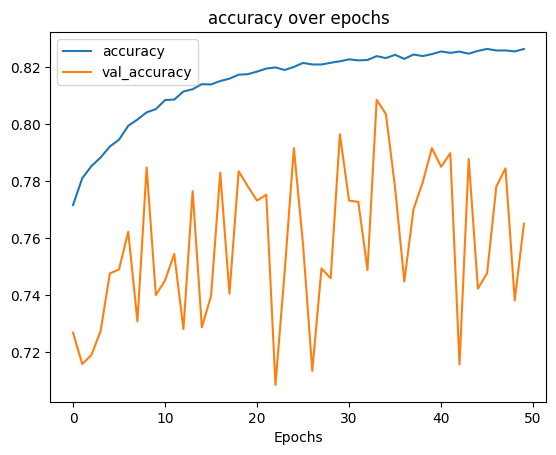

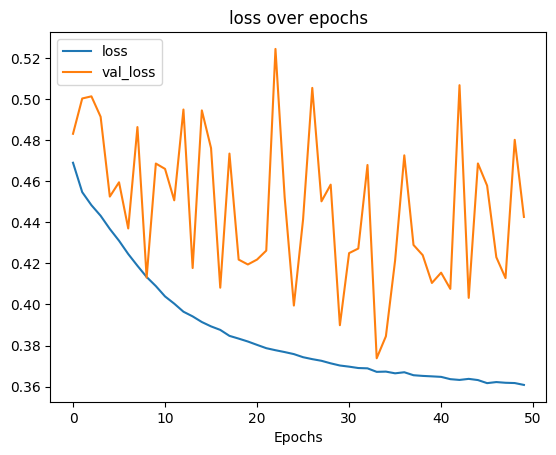

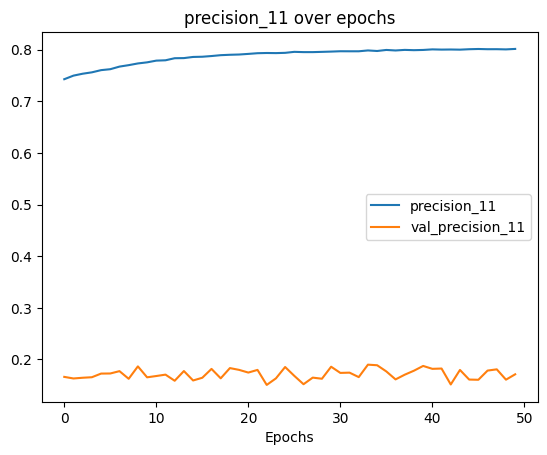

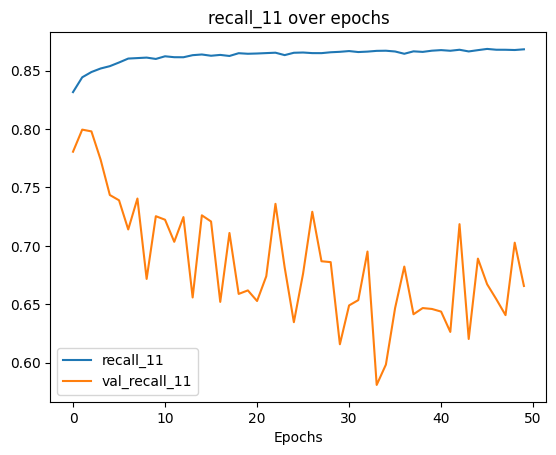

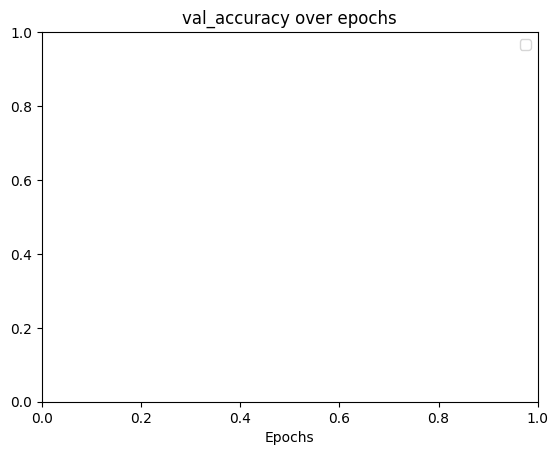

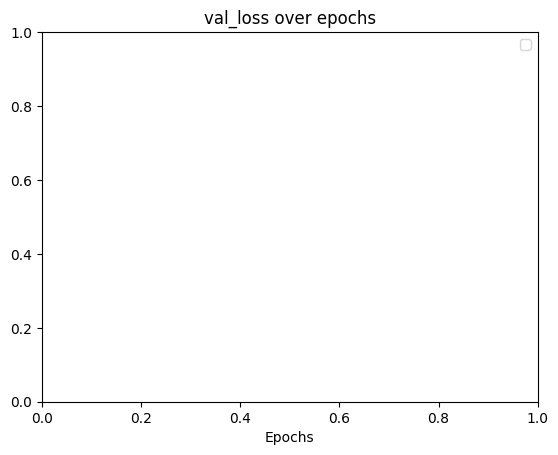

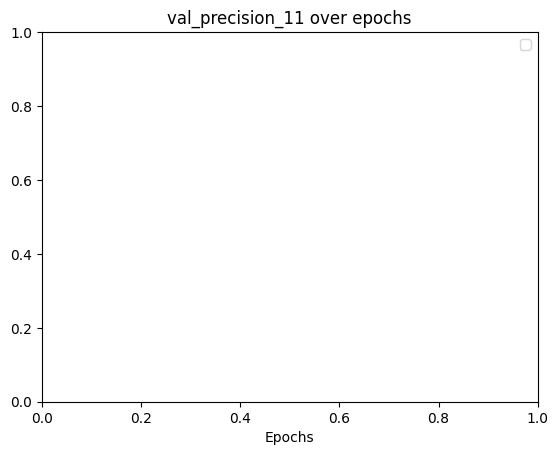

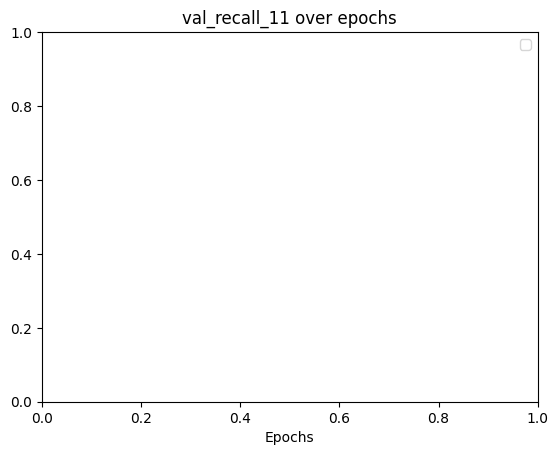

In [136]:
# plot the learning history_baseline
plot_history(history_baseline)

In [180]:
# FINAL EVALUATION
y_pred_base = baseline_clf_model.predict(X_test_processed).flatten()
y_pred = (y_pred_base >= 0.5).astype(int)
print(classification_report(y_test, y_pred, target_names=['No Event', 'CVD Event']))

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
              precision    recall  f1-score   support

    No Event       0.95      0.42      0.58     18678
   CVD Event       0.08      0.71      0.14      1322

    accuracy                           0.44     20000
   macro avg       0.52      0.56      0.36     20000
weighted avg       0.90      0.44      0.55     20000



Improved Neural Network


In [137]:
print("="*70)
print("2. FINAL IMPROVED MODEL (SMOTE + Best Architecture)")
print("="*70)

2. FINAL IMPROVED MODEL (SMOTE + Best Architecture)


In [138]:
# # Apply SMOTE
# smote = SMOTE(random_state=42)
# X_train_res, y_train_res = smote.fit_resample(X_train_processed, y_train)
# print(f"After SMOTE → Class distribution: No Event={sum(y_train_res==0)}, Event={sum(y_train_res==1)}")

In [173]:
# Final model-architecture
final_model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(input_dim,)),
    Dropout(0.4),

    Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dropout(0.2),

    Dense(16, activation='relu'),
    Dropout(0.1),

    Dense(1, activation='sigmoid')
])

In [175]:
#compile
final_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', metrics.Precision(), metrics.Recall()]
 )
# , metrics.AUC(name='auc')

In [176]:
early_stop = EarlyStopping(monitor='accuracy', patience=15, restore_best_weights=True, verbose=0)

print("\nTraining Final Model...")
history_final=final_model.fit(X_train_res, y_train_res,
                validation_data=(X_test_processed, y_test),
                epochs=100,
                batch_size=512,
                callbacks=[early_stop],
                verbose=0)


Training Final Model...


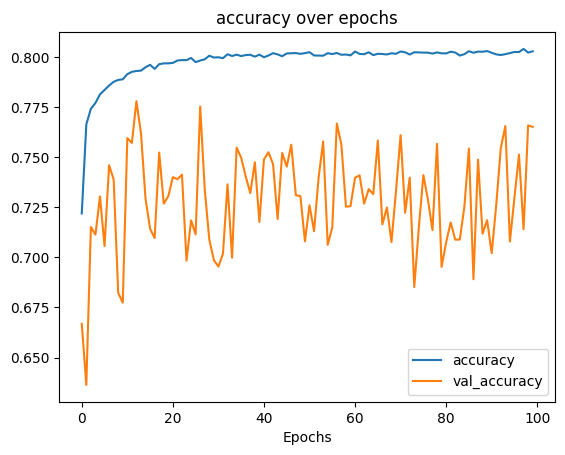

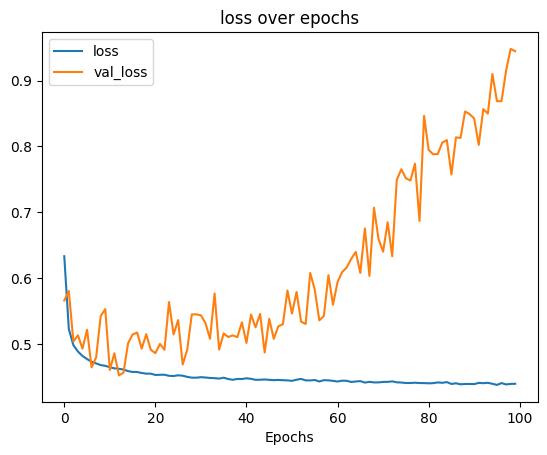

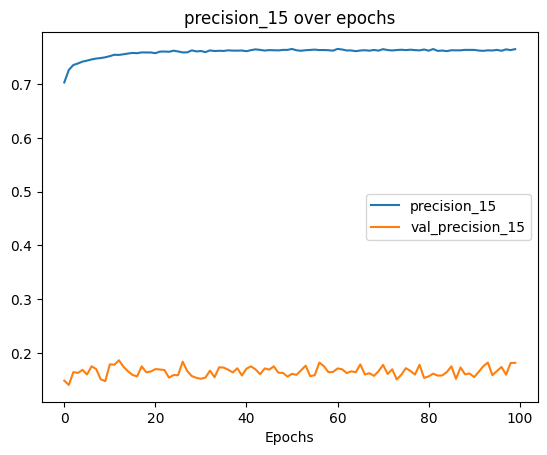

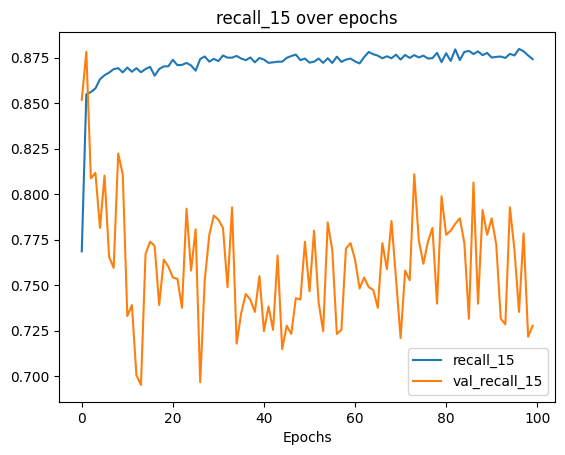

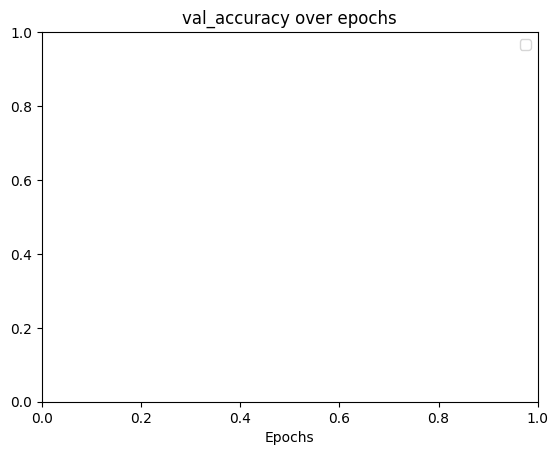

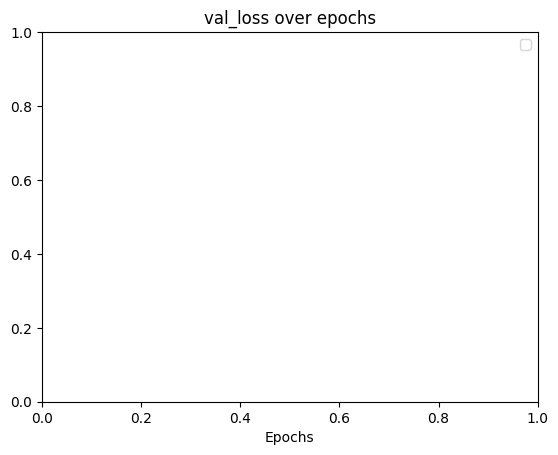

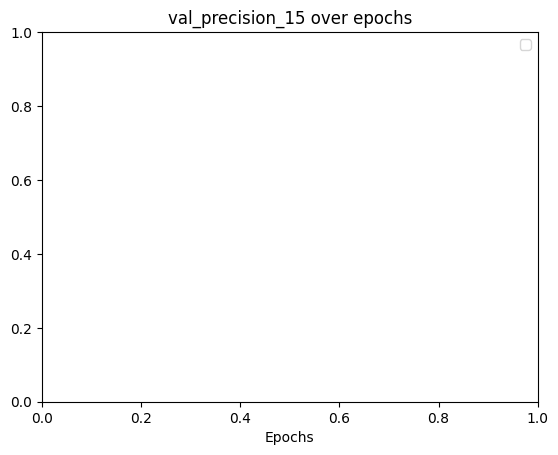

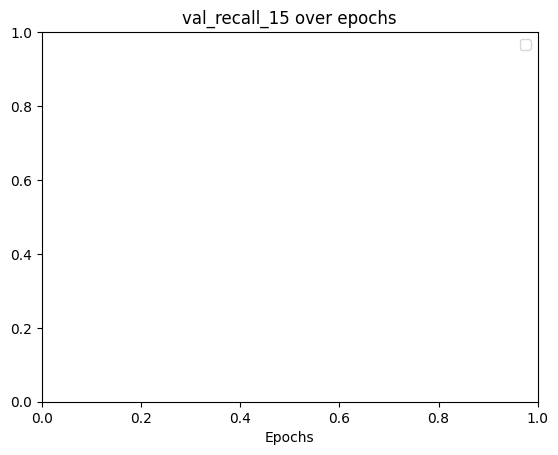

In [177]:
# plot the learning history_baseline
plot_history(history_final)

In [178]:
# FINAL EVALUATION
y_pred_proba = final_model.predict(X_test_processed).flatten()
y_pred = (y_pred_proba >= 0.5).astype(int)
print(classification_report(y_test, y_pred, target_names=['No Event', 'CVD Event']))

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
              precision    recall  f1-score   support

    No Event       0.98      0.71      0.82     18678
   CVD Event       0.16      0.78      0.26      1322

    accuracy                           0.71     20000
   macro avg       0.57      0.74      0.54     20000
weighted avg       0.92      0.71      0.79     20000



**lasts**

In [182]:
from tensorflow.keras.layers import BatchNormalization

improved_clf_model = Sequential()

improved_clf_model.add(Dense(64, activation='relu', input_shape=(input_dim,)))
improved_clf_model.add(Dropout(0.3))

improved_clf_model.add(Dense(32, activation='relu'))
improved_clf_model.add(Dropout(0.3))

improved_clf_model.add(Dense(16, activation='relu'))

# Output
improved_clf_model.add(Dense(1, activation='sigmoid'))

improved_clf_model.summary()


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_80 (Dense)                │ (None, 64)             │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,873 (30.75 KB)

 Trainable params: 7,873 (30.75 KB)

 Non-trainable params: 0 (0.00 B)

In [183]:
#Compile
improved_clf_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', metrics.Precision(), metrics.Recall()]
)


In [185]:
#Fit With More Epochs
history_improved = improved_clf_model.fit(
    X_train_res, y_train_res,
    validation_data=(X_test_processed, y_test),
    epochs=30,
    verbose=0
)


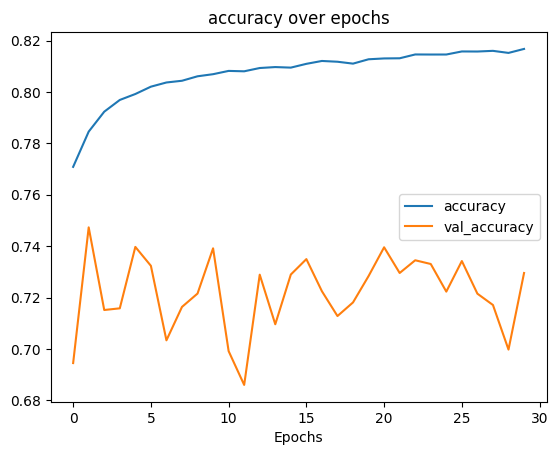

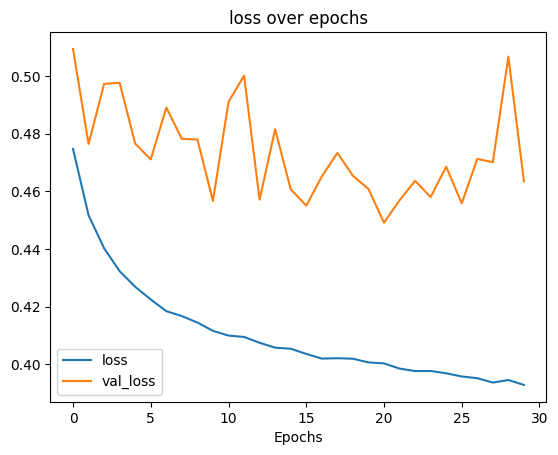

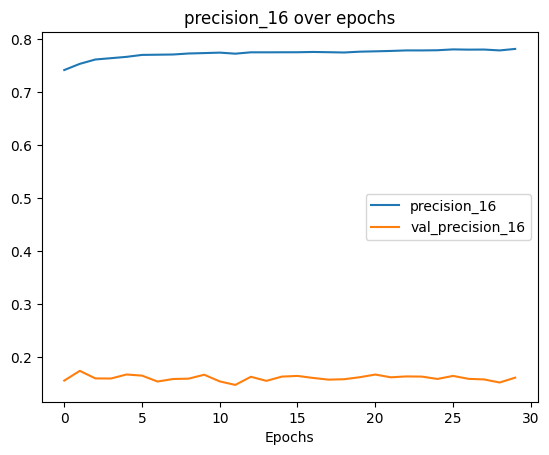

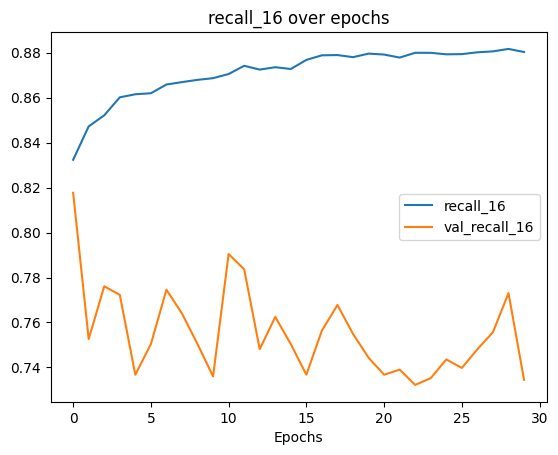

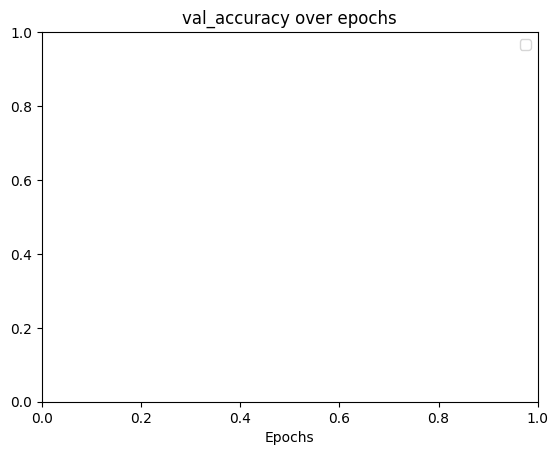

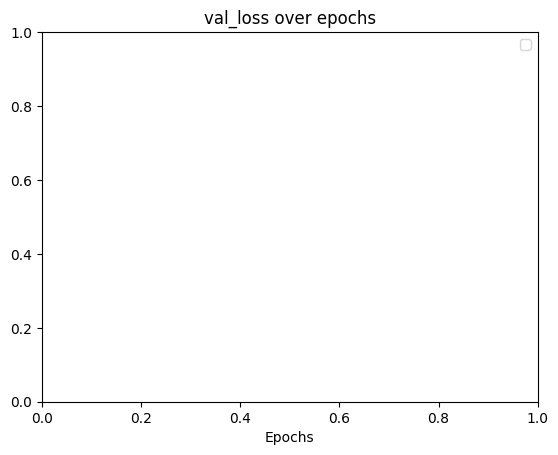

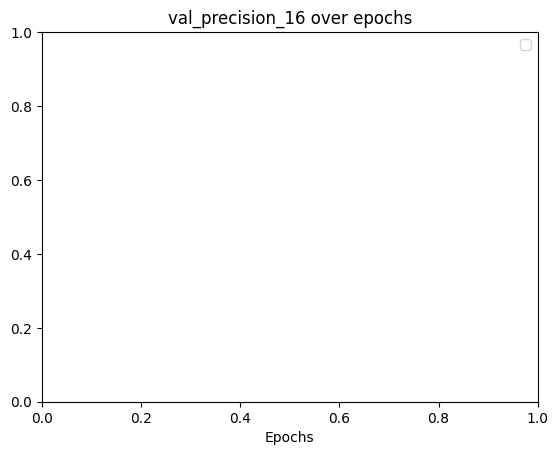

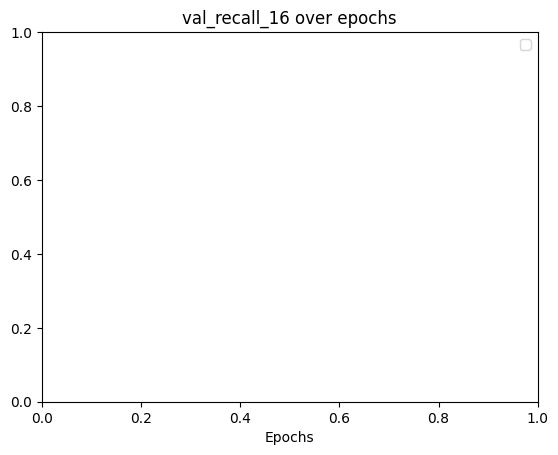

In [186]:
#Plot Learning Curve
plot_history(history_improved)


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
              precision    recall  f1-score   support

           0       0.97      0.73      0.83     18678
           1       0.16      0.73      0.26      1322

    accuracy                           0.73     20000
   macro avg       0.57      0.73      0.55     20000
weighted avg       0.92      0.73      0.80     20000



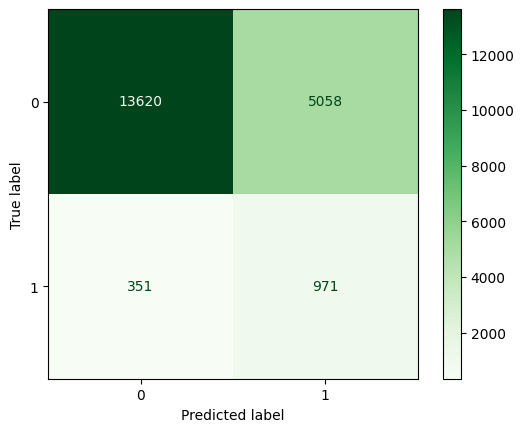

In [187]:
#Evaluate Improved Model
y_pred_proba22 = improved_clf_model.predict(X_test_processed)
y_pred22 = np.round(y_pred_proba22)

print(classification_report(y_test, y_pred22))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred22, cmap='Greens');


In [2]:
# import joblib
# #  SAVE THE MODEL TO DISK
# joblib.dump(history_improved, 'cvd_risk_rf_model.pkl')
# print("MODEL SAVED SUCCESSFULLY!")